<a href="https://colab.research.google.com/github/sikandarali164/PortfolioProject/blob/main/thesis3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

In [ ]:
!pip install --upgrade google-cloud-bigquery


In [ ]:
!pip install pandas-gbq


### Libraries

In [ ]:
import re  # Regular expression library, used for text processing and manipulation.
import numpy as np  # NumPy is used for numerical operations and array manipulation.
import pandas as pd  # Pandas is used for data manipulation and analysis, especially with data frames.
import random  # Used for generating random numbers or making random selections.
import time  # Used for measuring and tracking time, often for performance analysis.
import matplotlib.pyplot as plt  # Matplotlib is a library for data visualization, used to create plots and graphs.
import seaborn as sns
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split  # scikit-learn library for splitting datasets into training and testing sets.
from sklearn.metrics import (f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc,precision_score)
from sklearn.feature_extraction.text import CountVectorizer
# scikit-learn provides various metrics and evaluation functions for machine learning models.
from wordcloud import WordCloud
import torch  # PyTorch is a deep learning library, used for building and training neural networks.
import torch.nn as nn  # Part of PyTorch, used for defining neural network layers and models.
import torch.nn.functional as F  # Provides various neural network activation functions.
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler,Dataset)
from torch.nn.modules import transformer  # PyTorch's transformer module for implementing transformer models.
# PyTorch data utilities for creating datasets and data loaders for training models.
import torch.optim as optim


from transformers import (BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup)
# Hugging Face Transformers library, which provides pre-trained models and tokenizers for NLP tasks.
# to get the data from bigquery
from google.cloud import bigquery
from google.colab import auth
# Getting the words from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer







[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Uncomment when Bigquery database authorization is accessible
#auth.authenticate_user()

In [ ]:

#Uncomment when Bigquery database authorization is accessible
#project_id = 'sound-machine-404420'

# Create a BigQuery client
#client = bigquery.Client(project=project_id)


In [ ]:
#Uncomment when Bigquery database authorization is accessible
"""
sql_queries = [
    "SELECT Text as text,sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.Multi-Domain where sarcasm is not null`",
    "SELECT  review as text,label as sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.Product_Review where label is not null`",
    "SELECT tweet as text,sarcastic as sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.twitter` where sarcasm is not null"
]
"""

'\nsql_queries = [\n    "SELECT Text as text,sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.Multi-Domain where sarcasm is not null`",\n    "SELECT  review as text,label as sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.Product_Review where label is not null`",\n    "SELECT tweet as text,sarcastic as sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.twitter` where sarcasm is not null"\n]\n'

In [ ]:
#Uncomment when Bigquery database authorization is accessible
#sql_queries2="SELECT Text as text,sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.Multi-Domain` union all SELECT  review as text,label as sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.Product_Review` union all SELECT   tweet as text,sarcastic as sarcasm FROM `sound-machine-404420.Amazon_Product_Reviews.twitter`"

In [ ]:
# Intialize the variable before storing the data
dataset1_df = None
dataset2_df = None
dataset3_df = None
#Uncomment when Bigquery database authorization is accessible
"""
# Iterate through queries and datasets
for i, sql_query in enumerate(sql_queries):
    # Execute the query and convert the result to a Pandas DataFrame
    current_df = client.query(sql_query).to_dataframe()

    # Assign the DataFrame to the respective variable
    if i == 0:
        dataset1_df = current_df
    elif i == 1:
        dataset2_df = current_df
    elif i == 2:
        dataset3_df = current_df
"""
# List of datasets (Pandas DataFrames)
dataset1_df= pd.read_csv('Multi-Domain.csv')
dataset2_df = pd.read_csv('Amazon_product_reviews.csv')
dataset3_df= pd.read_csv('Twitter.csv')

# renaming the dataset column to have consistency in training
dataset1_df.rename(columns={'Text': 'text'}, inplace=True)
dataset2_df.rename(columns={'review': 'text'}, inplace=True)
dataset2_df.rename(columns={'label': 'sarcasm'}, inplace=True)
dataset3_df.rename(columns={'tweet': 'text'}, inplace=True)
# Checking for null values
def handle_null_values(df, dataset_name):
    if df.isnull().values.any():
        print(f"Null values found in {dataset_name}:")
        print(df.isnull().sum())
        df = df.dropna()
    return df
# making the list of the dataset
datasets = [
    dataset1_df,
    dataset2_df,
    dataset3_df
]

# checking for the null value in each dataset and removing them
for i, data in enumerate(datasets):
    datasets[i] = handle_null_values(data, f"Dataset{i+1}")
    print("\n")


    rows,columns=datasets[i].shape
    # Create a PrettyTable for visualization
    table = PrettyTable()
    # Print the shape of the dataset before splitting
    before_split_table = PrettyTable(["Dataset", "Shape"])
    before_split_table.add_row(["Original", datasets[i].shape])
    print("\n")
    print(f"Shape of the dataset before splitting:{i+1}")
    print(before_split_table)
    print("\n")
# Add a 'dataset' column to each dataset to distinguish between them
dataset1_df['dataset'] = 'Multi Domain'
dataset2_df['dataset'] = 'Product Review'
dataset3_df['dataset'] = 'twitter'






Shape of the dataset before splitting:1
+----------+-----------+
| Dataset  |   Shape   |
+----------+-----------+
| Original | (1016, 2) |
+----------+-----------+






Shape of the dataset before splitting:2
+----------+-----------+
| Dataset  |   Shape   |
+----------+-----------+
| Original | (1245, 7) |
+----------+-----------+


Null values found in Dataset3:
ID                        0
text                      1
sarcastic                 0
sarcasm                2601
irony                  2601
satire                 2601
understatement         2601
overstatement          2601
rhetorical_question    2601
dtype: int64




Shape of the dataset before splitting:3
+----------+----------+
| Dataset  |  Shape   |
+----------+----------+
| Original | (867, 9) |
+----------+----------+




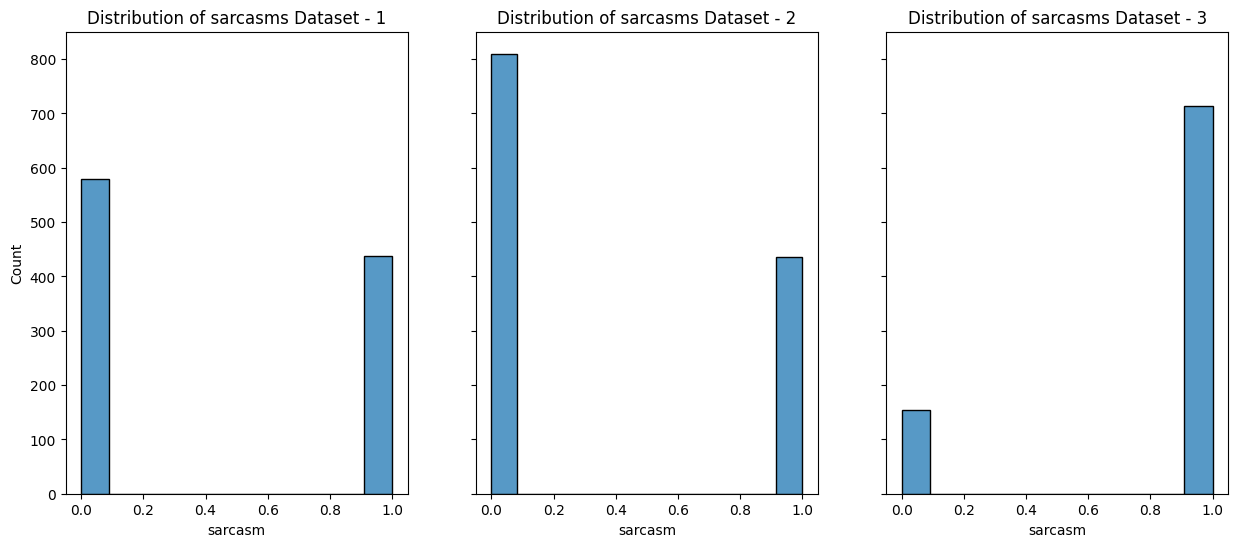

In [ ]:
# ploting a histrogram to check for the outlier and see if there is the anomly and then be removed using finding the quartlile
# over here we have not used the remove function as there are no outlier
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(15, 6), sharey=True)

    # Plot word count distribution for each dataset
for i, dataset in enumerate(datasets):
  sns.histplot(data=dataset['sarcasm'], ax=axes[i])

  axes[i].set_title(f'Distribution of sarcasms Dataset - {i+1}')


plt.show()

In [ ]:
#  ploting the sarcasm distribution to compare the instance within each dataset
def compare_distributions(*datasets):
    # Combine the datasets
    combined_dataset = pd.concat(datasets, ignore_index=True)

    # Visualize the distribution with Seaborn using 'hue' to distinguish between datasets
    sns.countplot(x='sarcasm', hue='dataset', data=combined_dataset)
    plt.title('Distribution of Sarcasm vs. Non-Sarcasm across Datasets')
    plt.xlabel('Sarcasm')
    plt.ylabel('Count')
    plt.show()





In [ ]:
# generating the word cloud to see which words are being used alot and visulaizing them
def compare_wordclouds(*datasets, dataset_names=None):
    # Initialize subplots
    num_datasets = len(datasets)
    fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(15, 6))

    # Plot word cloud for each dataset
    for i, dataset in enumerate(datasets):
        # Combine all texts into a single string
        all_texts = ' '.join(dataset['text'])

        # Generate word cloud
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate(all_texts)

        # Plot word cloud
        title = dataset_names[i] if dataset_names else f'Dataset {i+1}'
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'Word Cloud - {title}')

    axes[num_datasets - 1].axis('off')

    #plt.tight_layout()
    plt.show()






In [ ]:
# generating the word length of review and see how many are there in each dataset
def compare_wordcounts(*datasets, dataset_names=None):


    # Initialize subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(15, 6), sharey=True)

    # Plot word count distribution for each dataset
    for i, dataset in enumerate(datasets):
        sns.histplot(data=dataset['text'].apply(lambda x: len(str(x).split())), bins=30, kde=True, ax=axes[i])
        title = dataset_names[i] if dataset_names else f'Dataset {i+1}'
        axes[i].set_title(f'Word Count Distribution - {title}')
        axes[i].set_xlabel('Word Count')
        axes[i].set_ylabel('Frequency')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()





In [ ]:
# generating the word length of review,further categoring them in sarcasm/non-sarcasm  and see how many are there in each dataset
def compare_wordcounts_sarcasm(*datasets, dataset_names=None):
  # Initialize subplots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)

  # Plot word count distribution for each dataset
  for i, dataset in enumerate(datasets):
      # Filter dataset for sarcasm and non-sarcasm instances
      sarcasm_data = dataset[dataset['sarcasm'] == 1]['text'].apply(lambda x: len(str(x).split()))
      non_sarcasm_data = dataset[dataset['sarcasm'] == 0]['text'].apply(lambda x: len(str(x).split()))

      # Plot histograms for sarcasm
      sns.histplot(data=sarcasm_data, bins=30, kde=True, color='orange', label='Sarcasm', ax=axes[0, i])
      title = dataset_names[i] if dataset_names else f'Dataset {i+1}'
      axes[0, i].set_title(f'Sarcasm - Dataset {title}')
      axes[0, i].set_xlabel('Word Count')
      axes[0, i].set_ylabel('Frequency')
      axes[0, i].tick_params(axis='x', rotation=45)
      axes[0, i].legend()

      # Plot histograms for non-sarcasm
      sns.histplot(data=non_sarcasm_data, bins=30, kde=True, color='blue', label='Non-Sarcasm', ax=axes[1, i])
      axes[1, i].set_title(f'Non-Sarcasm - Dataset {title}')
      axes[1, i].set_xlabel('Word Count')
      axes[1, i].set_ylabel('Frequency')
      axes[1, i].tick_params(axis='x', rotation=45)
      axes[1, i].legend()

  plt.tight_layout()
  plt.show()


In [ ]:
# split the data to train and test the modle
def split(combined_data_cleaned):
  X = combined_data_cleaned.text.values
  y = combined_data_cleaned.sarcasm.values
  # converting to array
  y=np.array(y)
  # converting to float type
  y = y.astype(float)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

  return X_train, X_test, y_train, y_test


In [ ]:
# removing the noise from each review
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters, URLs, and mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters

     # Change 't to 'not'
    text = re.sub(r"\'t", " not", text)
    # Remove @name
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    # Isolate and remove punctuations except '?'
    text = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', text)
    text = re.sub(r'[^\w\s\?]', ' ', text)
    # Remove some special characters
    text = re.sub(r'([\;\:\|•«\n])', ' ', text)
    # Remove stopwords except 'not' and 'can'
    text = " ".join([word for word in text.split() if word not in stopwords.words('english') ])
    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # (split text into words)
    words = text.split()
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a single string
    processed_text = ' '.join(words)

    return processed_text








In [ ]:
# fetching the tokenizer from hugging face
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# tokenizing and preprocessing the reviews
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=preprocess_text(sent),
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_attention_mask=True
        )

        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Building Bert Model
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits


In [ ]:
# intialize the bert model
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    # running on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    total_steps = len(train_dataloader) * epochs


    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


In [ ]:
def plottrain(history):
    epochs = [i + 1 for i in range(len(history['train_loss']))]  # Adjust epochs accordingly
    fig, ax = plt.subplots(1, 2)
    train_acc = history['train_accuracy']  # Use 'val_accuracy' for validation accuracy
    train_loss = history['train_loss']  # Use 'train_loss' for training loss
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']

    fig.set_size_inches(20, 10)

    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()


In [ ]:
# to predict the probabilties generated by BERT with softmax
def bert_predict(model, test_dataloader):

    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:


# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    history = {'train_loss': [],'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch_i in range(epochs):



        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            b_labels = b_labels.to(torch.long)  # Convert target labels to 'Long' data type

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                batch_loss, batch_counts = 0, 0


        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

    #    print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            train_loss, train_accuracy = evaluate(model, train_dataloader)
            val_loss, val_accuracy = evaluate(model, val_dataloader)

        # Store training history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['train_accuracy'].append(train_accuracy)
  #  print("Training complete!")
    return history



In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        b_labels = b_labels.to(torch.long)  # Convert target labels to 'Long' data type

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [ ]:
# genrating the confusion matrix
def plot_confusion_matrix(y_test,preds):
  cm = confusion_matrix(y_test,preds)
  plt.figure(figsize = (10,10))
  sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
  plt.xlabel("Predicted")
  plt.ylabel("Actual")

  # Extract TP and FP values from the confusion matrix
  TP = cm[1, 1]  # True Positives (1,1) in a 2x2 confusion matrix
  FP = cm[0, 1]  # False Positives (0,1) in a 2x2 confusion matrix

  print("True Positives (TP):", TP)
  print("False Positives (FP):", FP)

In [ ]:
# computing the roc of each dataset
def evaluate_roc(probs, labels):
    # Compute ROC curve and ROC area for each class
    if len(probs.shape) == 2:
        # If the array has two dimensions, take the second column
        fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    else:
        # If the array is 1D, use it directly
        fpr, tpr, _ = roc_curve(labels, probs)

    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc
# Evaluate the Bert classifier



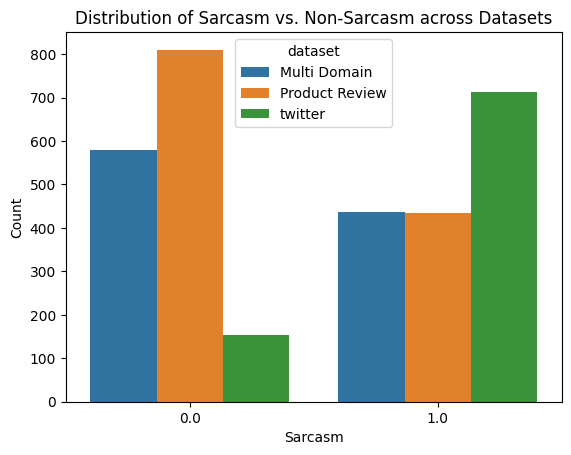

In [ ]:
# calling the function to generate the distribution plot
compare_distributions(dataset1_df, dataset2_df, dataset3_df)

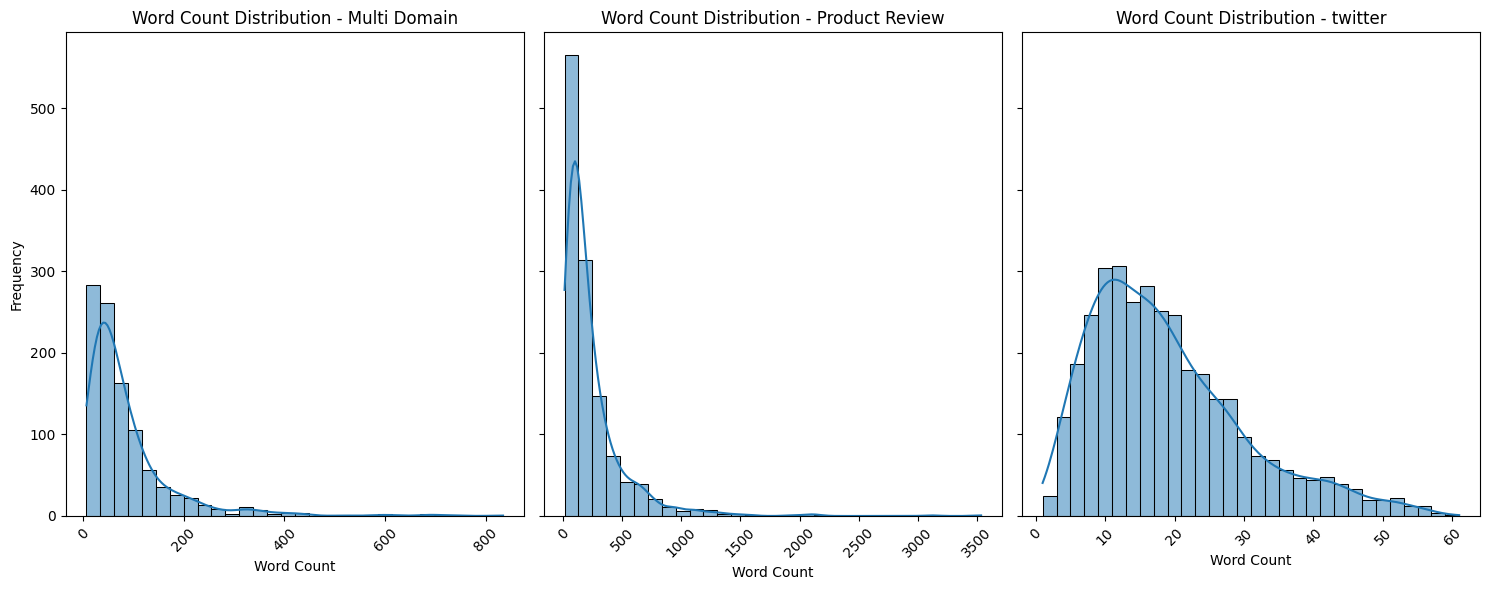

In [ ]:
# calling the function to generate the count plot
compare_wordcounts(dataset1_df, dataset2_df, dataset3_df, dataset_names=['Multi Domain', 'Product Review', 'twitter'])

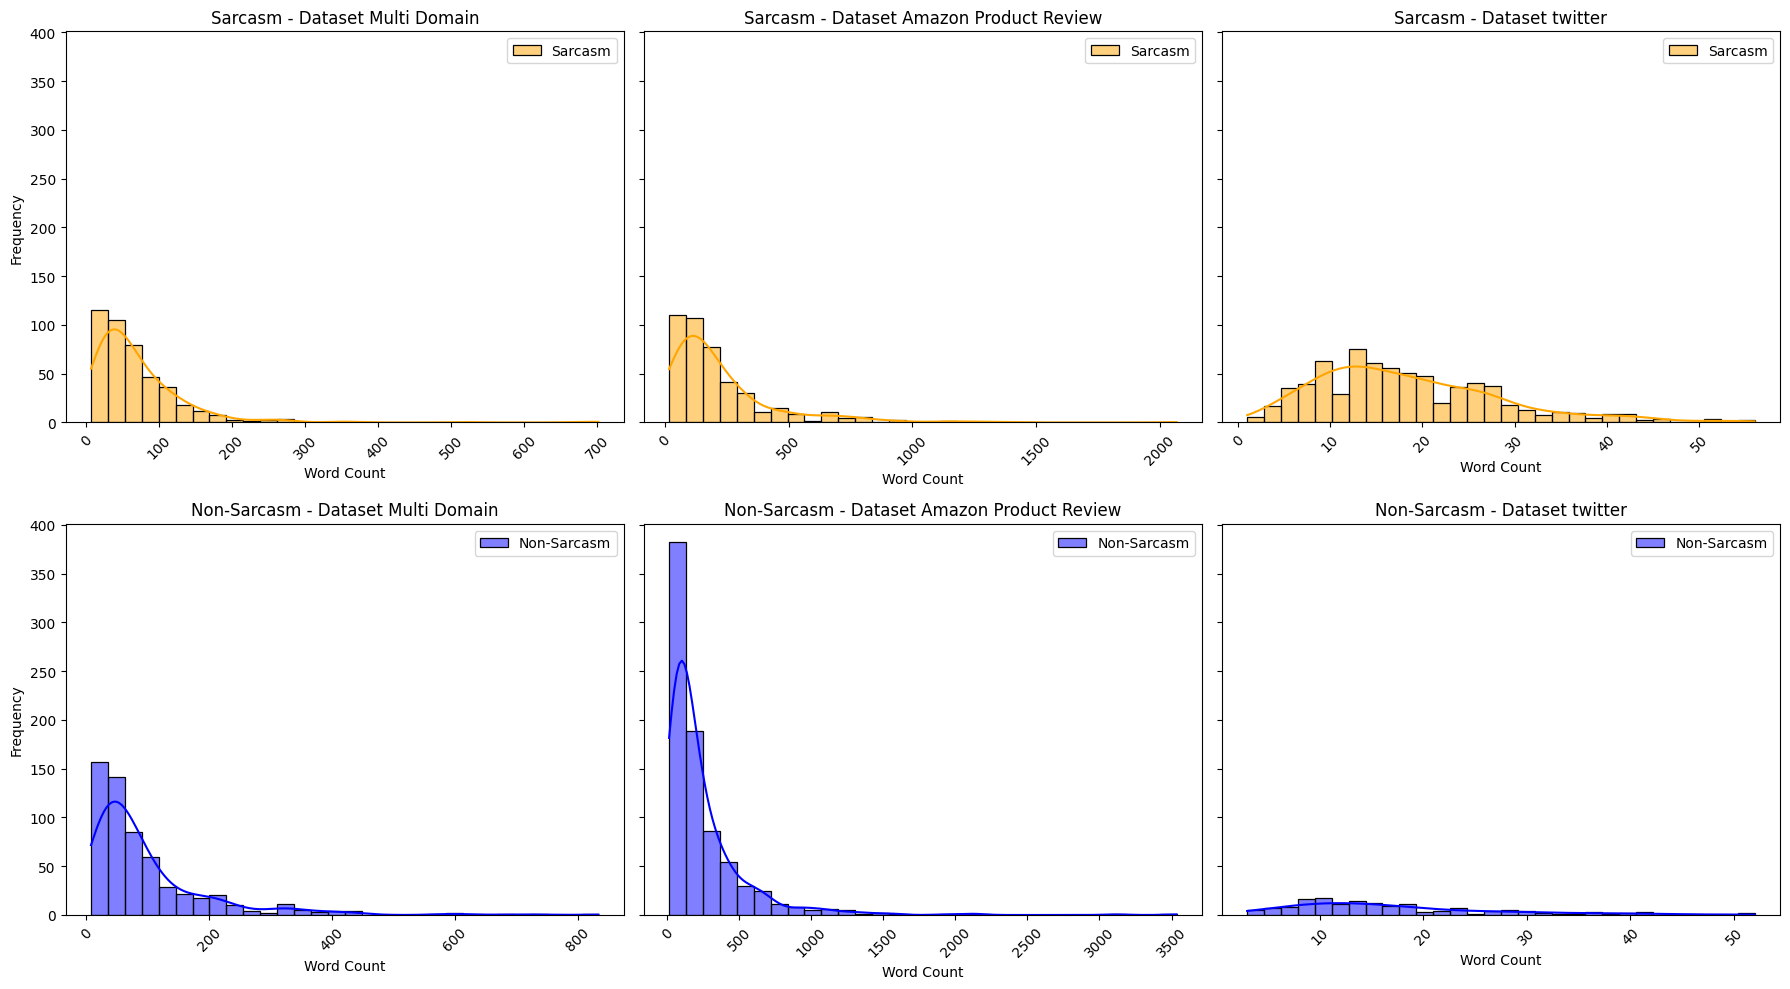

In [ ]:
# calling the function to generate the count plot with the category of sarcasm and non-sarcasm
compare_wordcounts_sarcasm(dataset1_df, dataset2_df, dataset3_df, dataset_names=['Multi Domain', 'Amazon Product Review', 'twitter'])

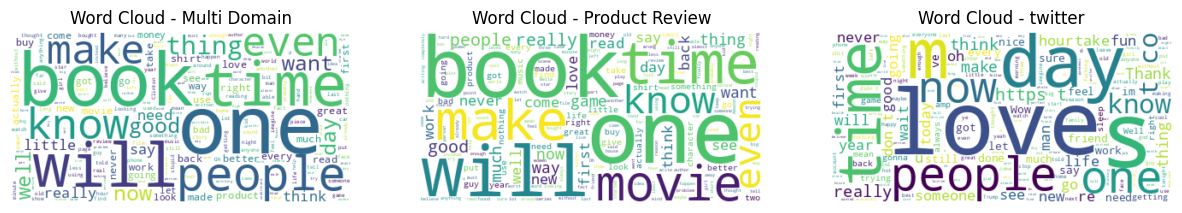

In [ ]:
# calling the function to generate the word cloud plot
compare_wordclouds(dataset1_df[dataset1_df['sarcasm'] == 1], dataset2_df[dataset2_df['sarcasm'] == 1], dataset3_df[dataset3_df['sarcasm'] == 1], dataset_names=['Multi Domain', 'Product Review', 'twitter'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Shape of the dataset before splitting:
+----------+-----------+
| Dataset  |   Shape   |
+----------+-----------+
| Original | (1016, 2) |
+----------+-----------+



Shape of the dataset after splitting:
+----------+----------------+--------------+
| Dataset  | Features Shape | Labels Shape |
+----------+----------------+--------------+
| Training |     (812,)     |    (812,)    |
| Testing  |     (204,)     |    (204,)    |
+----------+----------------+--------------+
Original:  I like it very much, I use it in an outdoor trail camera for wild game and it hold several pictures and has been in the camera in all kinds of weather. I would buy Kingston again
Processed text:  like much use outdoor trail camera wild game hold several picture camera kind weather would buy kingston
Token IDs for X_train:  [101, 2066, 2172, 2224, 7254, 4446, 4950, 3748, 2208, 2907, 2195, 3861, 4950, 2785, 4633, 2052, 4965, 9803, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


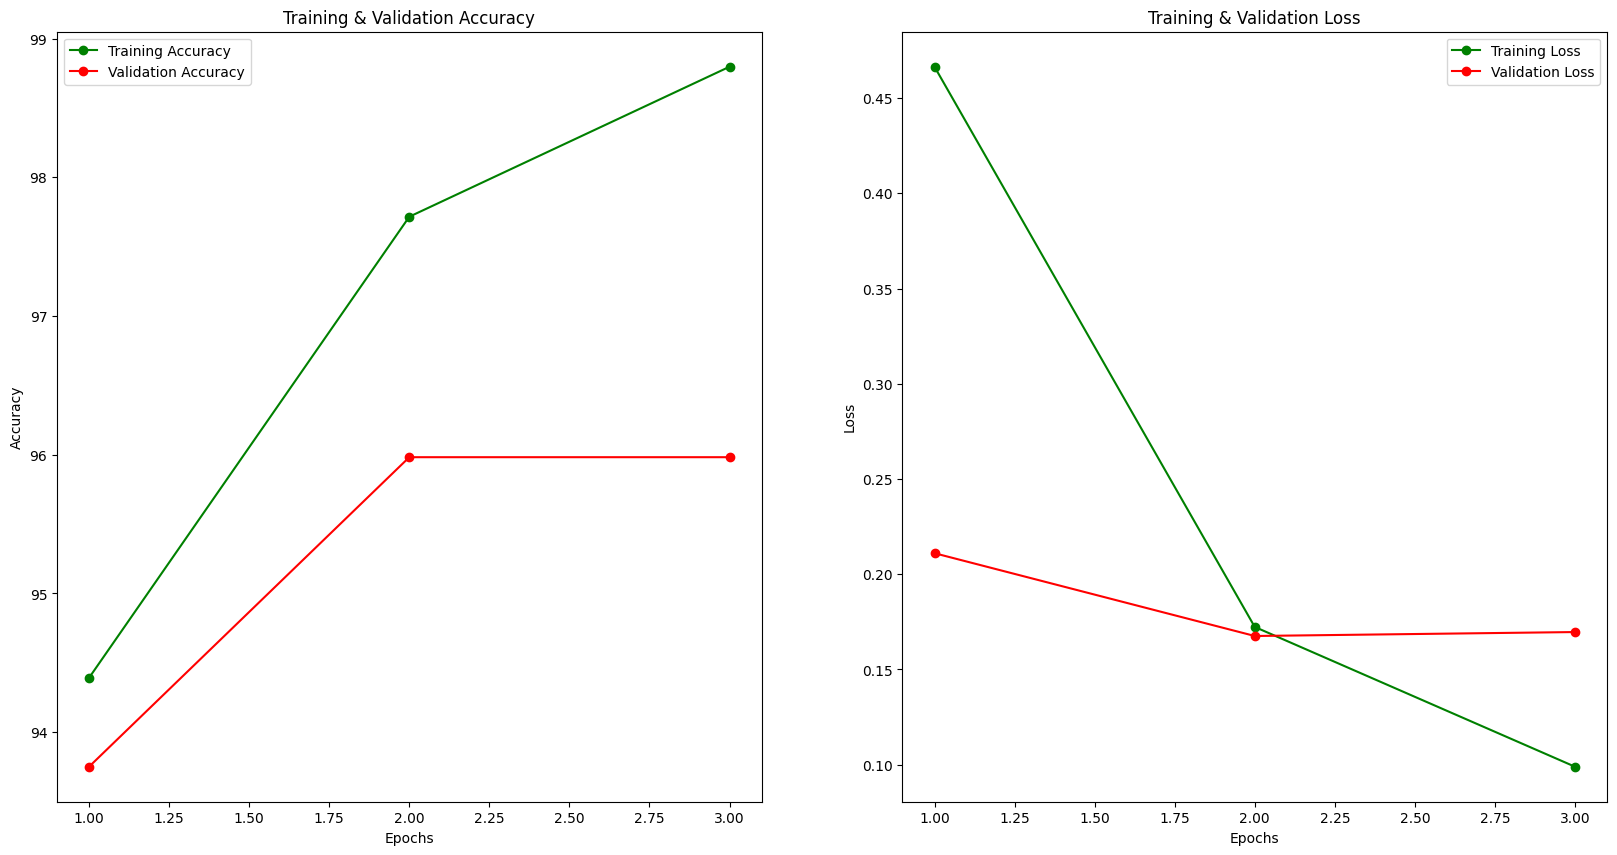

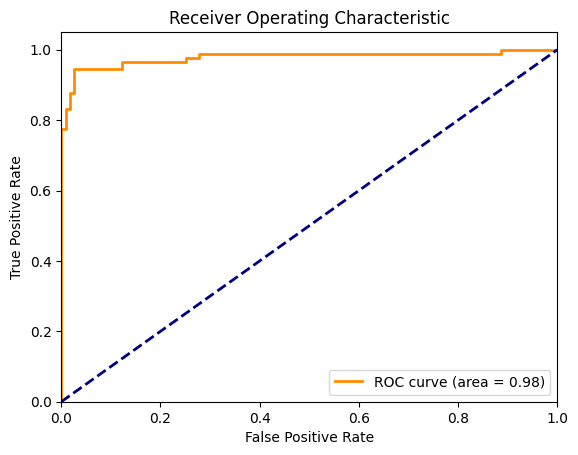



True Positives (TP): 84
False Positives (FP): 4
Shape of the dataset before splitting:
+----------+-----------+
| Dataset  |   Shape   |
+----------+-----------+
| Original | (1245, 2) |
+----------+-----------+



Shape of the dataset after splitting:
+----------+----------------+--------------+
| Dataset  | Features Shape | Labels Shape |
+----------+----------------+--------------+
| Training |     (996,)     |    (996,)    |
| Testing  |     (249,)     |    (249,)    |
+----------+----------------+--------------+
Original:  I bought these bibles to give as gifts to my friends that love stock car racing. They were impressed with the stories of the race drivers they found in the bible. I gave one to my church to help reach  young people that might otherwise not pickup a bible. I wish they would make one for motorcycle riders.  I am a member of CMA and would use this as an outreach tool.  Chris Cline, Overland Park, KS
Processed text:  bought bible give gift friend love stock car ra

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


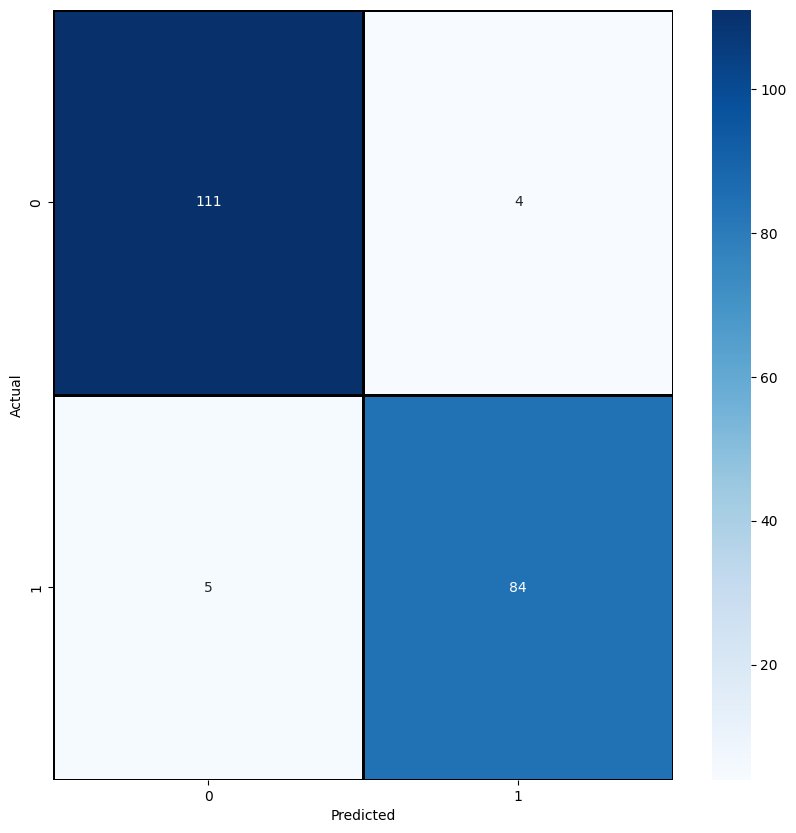

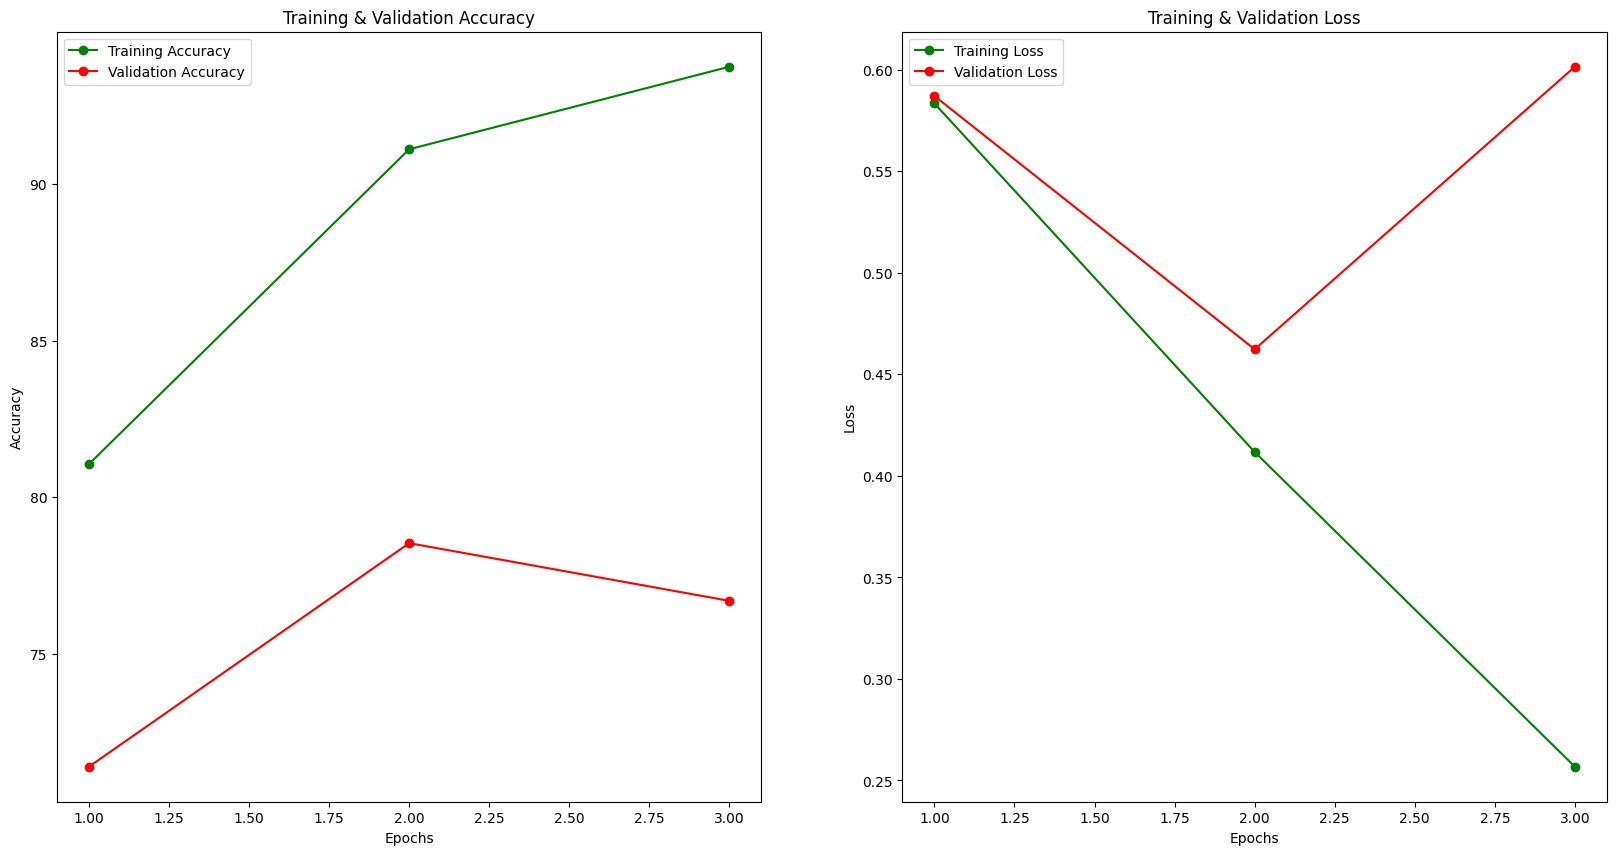

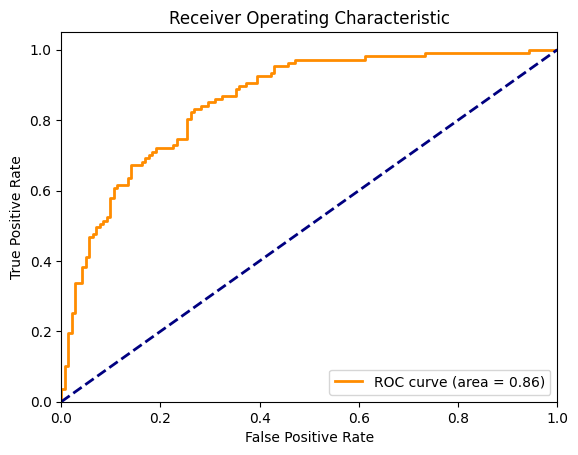



True Positives (TP): 65
False Positives (FP): 16
Shape of the dataset before splitting:
+----------+----------+
| Dataset  |  Shape   |
+----------+----------+
| Original | (867, 2) |
+----------+----------+



Shape of the dataset after splitting:
+----------+----------------+--------------+
| Dataset  | Features Shape | Labels Shape |
+----------+----------------+--------------+
| Training |     (693,)     |    (693,)    |
| Testing  |     (174,)     |    (174,)    |
+----------+----------------+--------------+
Original:  Broke: doing assignments in order of due date
Woke: doing assignments in order of priority
Wired: spending 20 minutes on each class at a time and just go down the list
Processed text:  broke assignment order due date woke assignment order priority wired spending minute class time go list
Token IDs for X_train:  [101, 3631, 8775, 2344, 2349, 3058, 8271, 8775, 2344, 9470, 17502, 5938, 3371, 2465, 2051, 2175, 2862, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


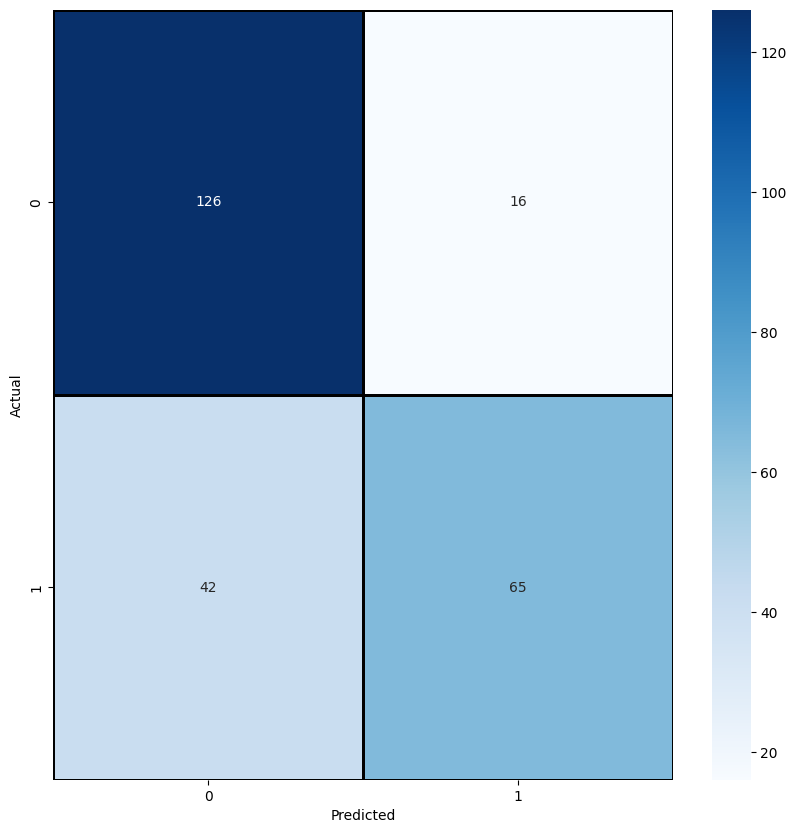

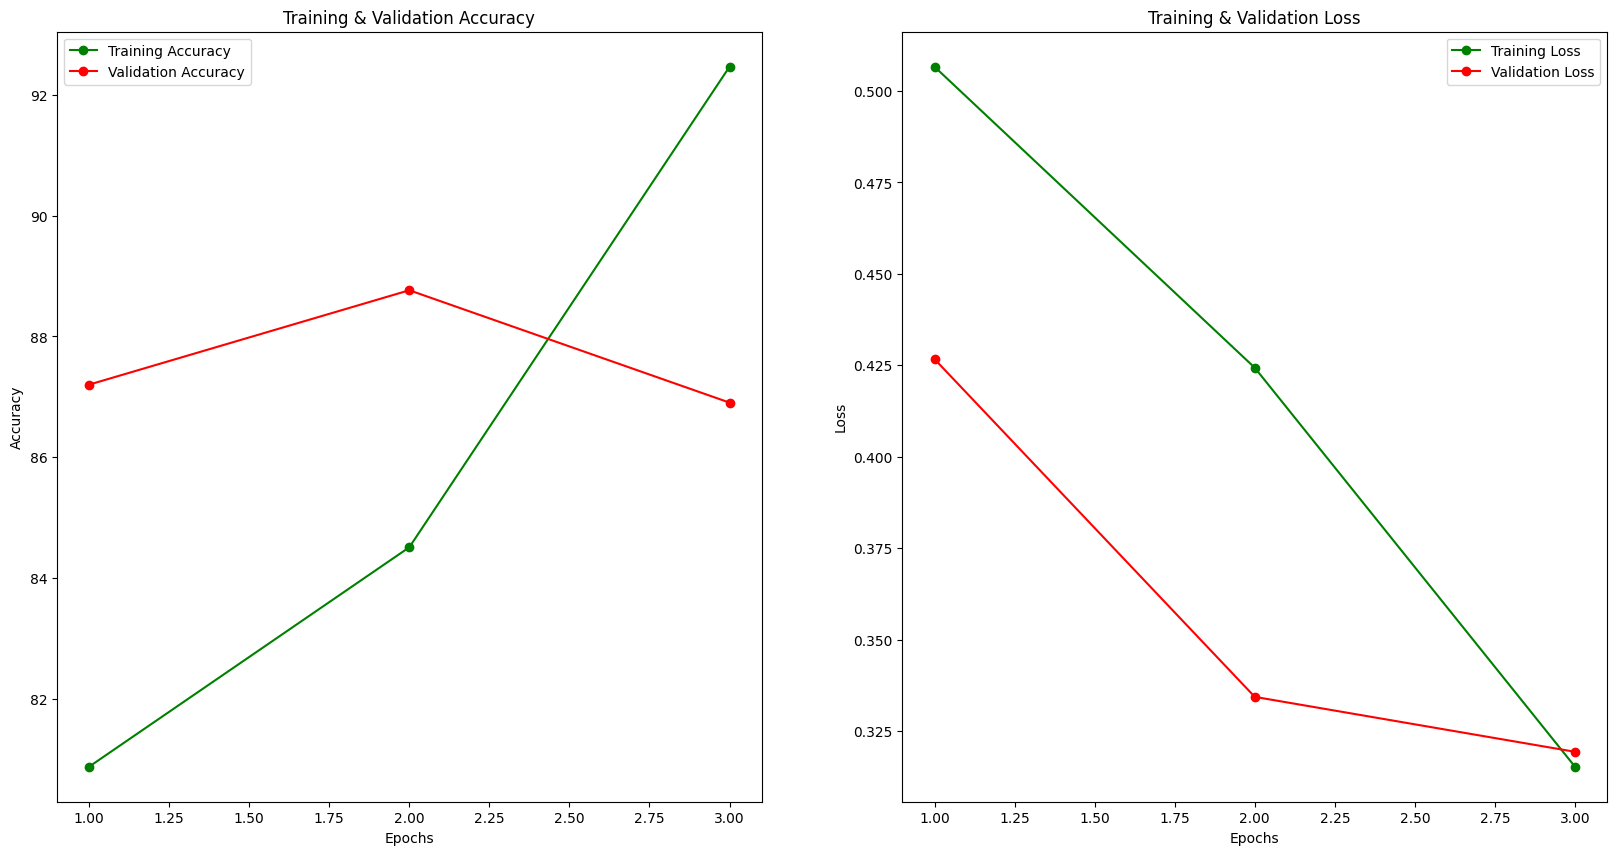

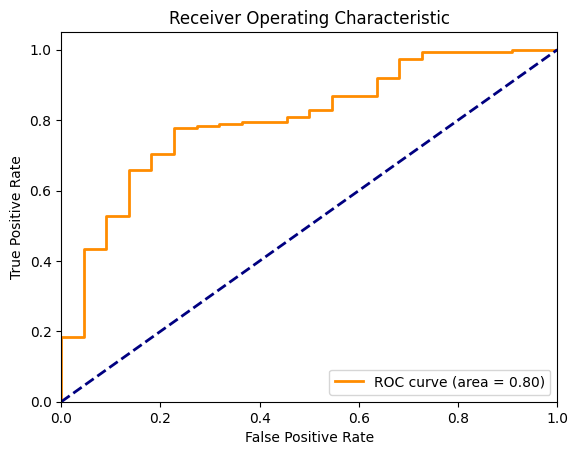



True Positives (TP): 148
False Positives (FP): 16
     Dataset  Accuracy  Precision   ROC AUC  F1 Score
0  Dataset 1  0.955882   0.954545  0.978310  0.949153
1  Dataset 2  0.767068   0.802469  0.856127  0.691489
2  Dataset 3  0.885057   0.902439  0.804127  0.936709


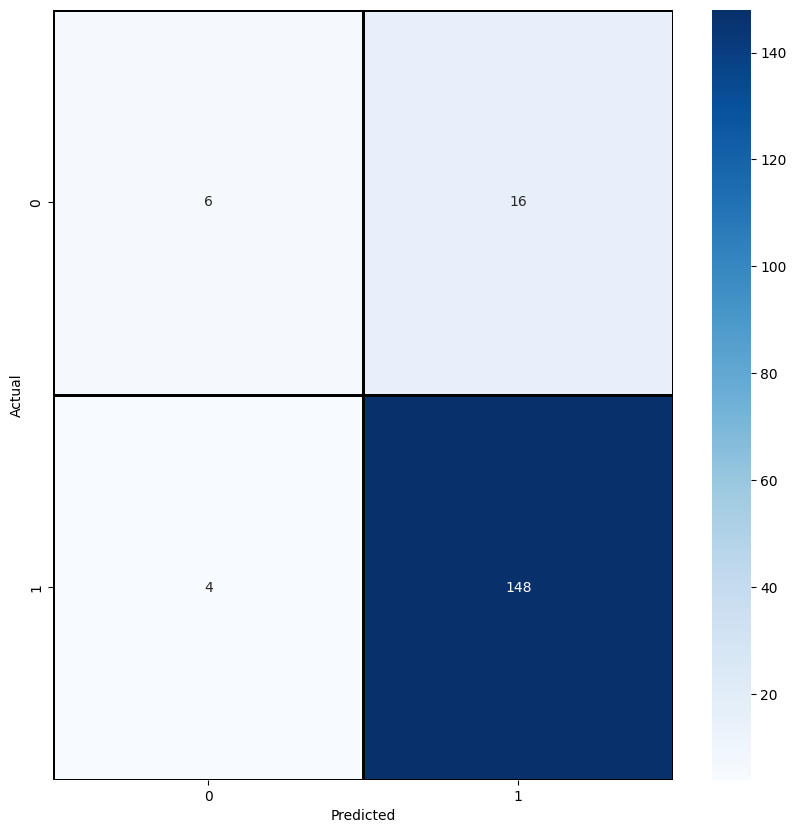

In [ ]:
# Intialize the varaiable to store in the list
accuracy_results = []
precision_results = []
roc_results = []
f1_scores_list = []


# Iterate through datasets
for dataset in datasets:
    # Assuming 'text' is the column containing your input text, and 'label' is the target variable
   if dataset is not None:
        # Keep only the 'text' and 'sarcasm' columns

        dataset = dataset[['text', 'sarcasm']]


        # getting the size of the dataset
        rows,columns=dataset.shape


        # Create a PrettyTable for visualization
        table = PrettyTable()
        # Print the shape of the dataset before splitting
        before_split_table = PrettyTable(["Dataset", "Shape"])
        before_split_table.add_row(["Original", dataset.shape])
        print("Shape of the dataset before splitting:")
        print(before_split_table)

        X_train, X_test, y_train, y_test=split(dataset)
        print("\n")
        # Print the shape of the dataset after splitting
        after_split_table = PrettyTable(["Dataset", "Features Shape", "Labels Shape"])
        after_split_table.add_row(["Training", X_train.shape, y_train.shape])
        after_split_table.add_row(["Testing", X_test.shape, y_test.shape])
        print("\nShape of the dataset after splitting:")
        print(after_split_table)
        # Specify `MAX_LEN`
        MAX_LEN = 100

        #Print sentence 0 and its encoded token ids from X_train
        token_ids_train = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
        print('Original: ', X_train[0])
        print('Processed text: ',preprocess_text(X_train[0]))
        print('Token IDs for X_train: ', token_ids_train)
        print("\n")
        # Print sentence 0 and its encoded token ids from X_test
        token_ids_test = list(preprocessing_for_bert([X_test[0]])[0].squeeze().numpy())
        print('Original: ', X_test[0])
        print('Processed text: ',preprocess_text(X_test[0]))
        print('Token IDs for X_test: ', token_ids_test)
        print("\n")




        # Create data loaders for training and testing using the new split
        train_inputs, train_masks = preprocessing_for_bert(X_train)
        test_inputs, test_masks = preprocessing_for_bert(X_test)

        train_labels = torch.tensor(y_train)
        test_labels = torch.tensor(y_test)



        # Create the DataLoader for the training set
        train_data = TensorDataset(train_inputs, train_masks, train_labels)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

        # Create the DataLoader for the testing set
        test_data = TensorDataset(test_inputs, test_masks, test_labels)
        test_sampler = SequentialSampler(test_data)
        test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



        # For fine-tuning BERT, recommend a batch size of 16 or 32.
        batch_size = 32

        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f'There are {torch.cuda.device_count()} GPU(s) available.')
            print('Device name:', torch.cuda.get_device_name(0))

        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")
        set_seed(10)  # Set seed for reproducibility
        bert_classifier, optimizer, scheduler = initialize_model(epochs=3)


        # Train the model
        history=train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)
        # plot the train set on each epoch
        plottrain(history)
        print("\n")
        # Tokenize the testing data (X_test)
        test_inputs, test_masks = preprocessing_for_bert(X_test)
        # Compute predicted probabilities on the test set
        probs = bert_predict(bert_classifier, test_dataloader)  # Assuming you have defined the bert_predict function
        roc_auc = evaluate_roc(probs, y_test)  # Assuming you have defined the evaluate_roc function
        threshold = 0.5
        preds = np.where(probs[:, 1] > threshold, 1, 0)
        print("\n")
        plot_confusion_matrix(y_test, preds)

        # Calculating the metrics
        f1 = f1_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds)

        # Append results to the lists
        f1_scores_list.append(f1)
        accuracy_results.append(accuracy)
        precision_results.append(precision)
        roc_results.append(roc_auc)

# Create a DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Dataset': [f'Dataset {i+1}' for i in range(len(datasets))],
    'Accuracy': accuracy_results,
    'Precision': precision_results,
    'ROC AUC': roc_results,
    'F1 Score': f1_scores_list  # Renamed the variable to avoid conflict
})

# Print the DataFrame
print(result_df)


In [ ]:
# Uncomment both when you want to predict your own text
# If you have train the model and you want to change the text please comment the train the model then change the text

dataset=datasets[1]
    # Assuming 'text' is the column containing your input text, and 'label' is the target variable
if dataset is not None:

        X_train, X_test, y_train, y_test=split(dataset)


        MAX_LEN = 100

        # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
        batch_size = 32
        # Create data loaders for training and testing using the new split
        train_inputs, train_masks = preprocessing_for_bert(X_train)
        test_inputs, test_masks = preprocessing_for_bert(X_test)

        train_labels = torch.tensor(y_train)
        test_labels = torch.tensor(y_test)



        # Create the DataLoader for the training set
        train_data = TensorDataset(train_inputs, train_masks, train_labels)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

        # Create the DataLoader for the testing set
        test_data = TensorDataset(test_inputs, test_masks, test_labels)
        test_sampler = SequentialSampler(test_data)
        test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)



        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f'There are {torch.cuda.device_count()} GPU(s) available.')
            print('Device name:', torch.cuda.get_device_name(0))

        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")
        set_seed(10)  # Set seed for reproducibility
        bert_classifier, optimizer, scheduler = initialize_model(epochs=3)



        # Train the model
        history=train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)


model = bert_classifier.to('cuda')  # Move the model to GPU

# Function to preprocess text for BERT
def preprocess_texts(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    attention_mask = (torch.tensor(input_ids) != 0).long()
    return torch.tensor(input_ids), attention_mask

# Function to predict sarcasm
def bert_predicts(model, input_ids, attention_mask):
    model.eval()
    with torch.no_grad():
        # Move input data to GPU
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')

        logits = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))[0]
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs

# Replace 'YOUR_TEXT_HERE' with the actual text you want to check for sarcasm
text_to_check = "I recently purchased this amazing product, and let me tell you, it totally lived up to my sky-high expectations. Not! I mean, who needs quality and reliability in a product, right? It's not like I wanted something that works seamlessly and enhances my daily life. The features are so mind-blowingly impractical and confusing that it's like they were designed to make my life more complicated. And the customer service? Oh, don't even get me started on how incredibly unhelpful they were. I can't recommend this product enough if you're looking for a headache and disappointment rolled into one!"
text_to_check1="I recently purchased this product, and I must say it exceeded my expectations. The quality is outstanding, and it delivers exactly what it promises. The features are practical and user-friendly, making it a valuable addition to my daily routine. I was particularly impressed with the excellent customer service—they addressed my inquiries promptly and professionally. Overall, I highly recommend this product to anyone looking for a reliable and top-notch solution."

# Preprocess text
input_ids, attention_mask = preprocess_texts(text_to_check)

#input_ids, attention_mask = preprocess_texts(text_to_check1)

# Make prediction
probs = bert_predicts(model, input_ids, attention_mask)

# Assuming you want to use the entire 'probs' array for classification
positive_class_prob = probs[1]

# Set a threshold for classification
threshold = 0.5
prediction = "Sarcastic" if positive_class_prob > threshold else "Not Sarcastic"

# Print the result
print(f"Predicted Probability for Positive Class: {positive_class_prob:.4f}")
print(f"Prediction: {prediction}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


There are 1 GPU(s) available.
Device name: Tesla T4


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Predicted Probability for Positive Class: 0.5154
Prediction: Sarcastic


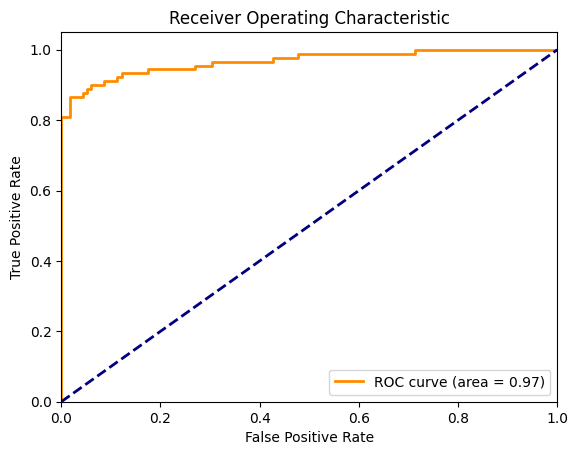



True Positives (TP): 77
False Positives (FP): 3




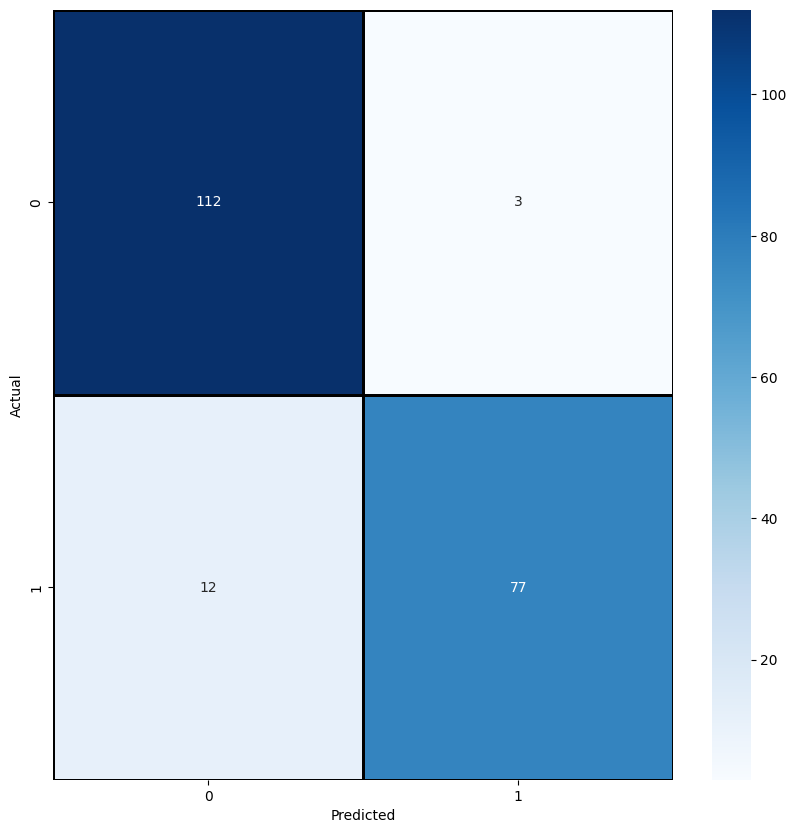

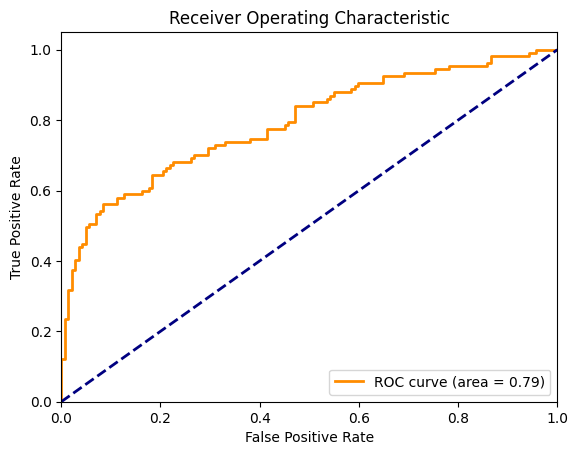



True Positives (TP): 45
False Positives (FP): 5




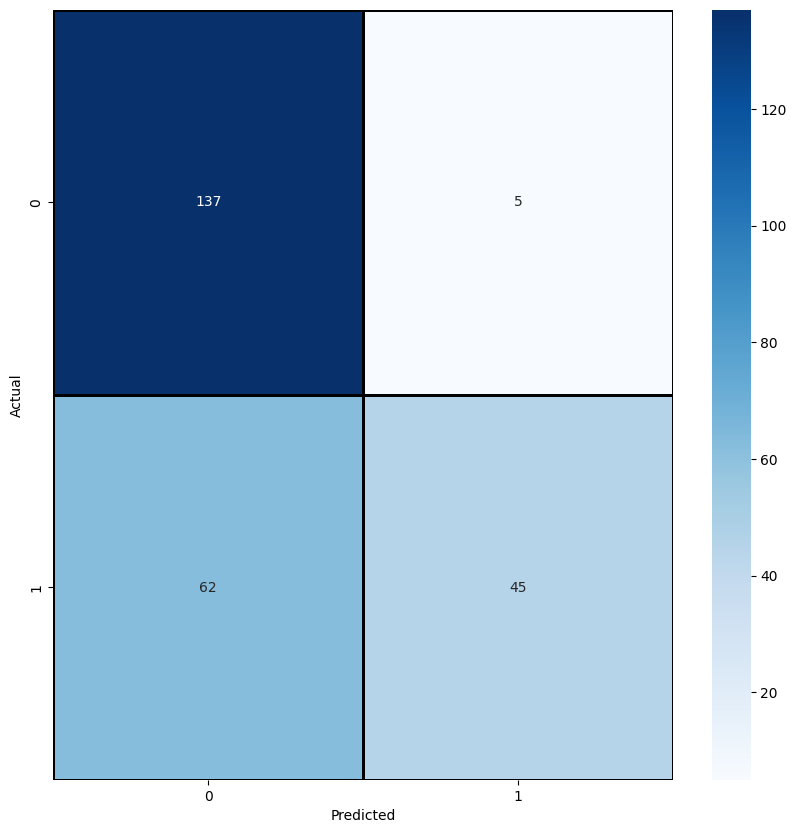

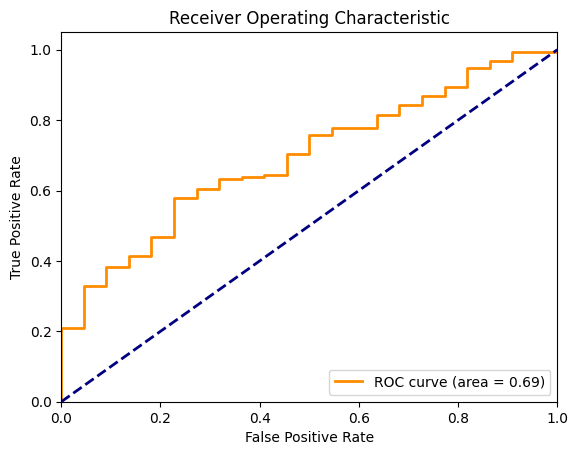



True Positives (TP): 152
False Positives (FP): 22


     Dataset  Accuracy  Precision   ROC AUC  F1 Score
0  Dataset 1  0.926471   0.962500  0.967074  0.911243
1  Dataset 2  0.730924   0.900000  0.792286  0.573248
2  Dataset 3  0.873563   0.873563  0.692584  0.932515


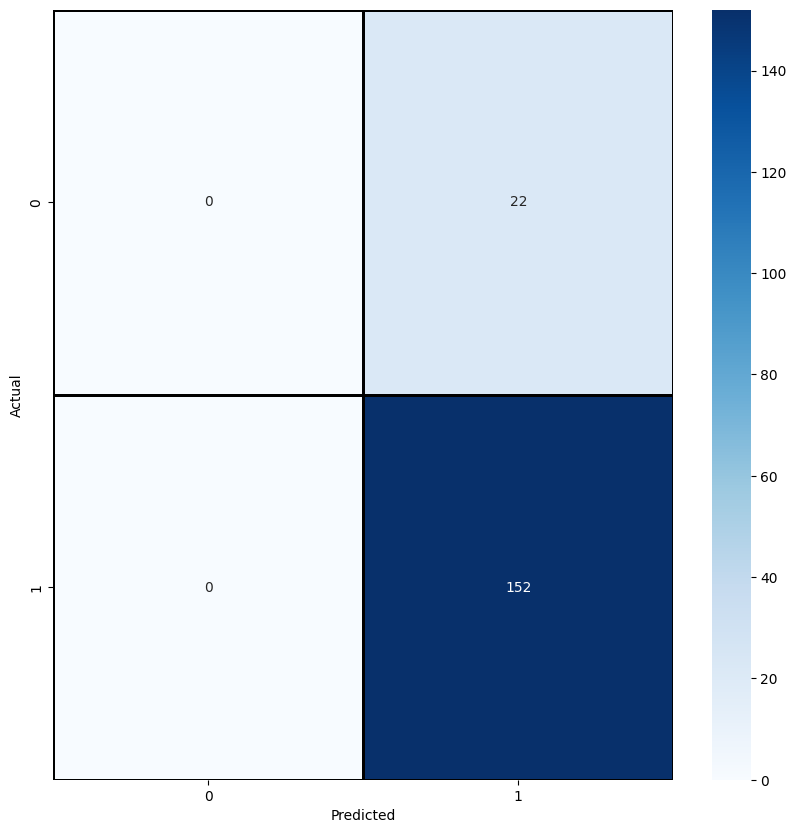

In [ ]:

# Create empty lists to store results
accuracy_results = []
precision_results = []
roc_results = []
f1_scores_list = []

# Define a custom dataset
class TextDataset(Dataset):
    def __init__(self, text, labels, vectorizer):
        self.text = text
        self.labels = labels
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        vectorized_text = self.vectorizer.transform([text]).toarray()[0]
        label = self.labels[idx]
        return torch.FloatTensor(vectorized_text), torch.LongTensor([label])

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Note the output size adjustment for bidirectional

    def forward(self, x):
        x = x.view(x.size(0), -1, self.input_size)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out




for dataset in datasets:
  X_train, X_test, y_train, y_test=split(dataset)
  # Create a CountVectorizer for text to convert it to numerical features
  vectorizer = CountVectorizer()
  X_train_vectorized = vectorizer.fit_transform(X_train)

  # Get feature names from the vectorizer
  feature_names = vectorizer.get_feature_names_out()

  # Create custom datasets and data loaders
  train_dataset = TextDataset(X_train, y_train, vectorizer)
  test_dataset = TextDataset(X_test, y_test, vectorizer)

  batch_size = 32

  # Create a CountVectorizer for text to convert it to numerical features
  vectorizer = CountVectorizer()
  X_train_vectorized = vectorizer.fit_transform(X_train)
  X_test_vectorized = vectorizer.transform(X_test)

  # Get feature names from the vectorizer
  feature_names = vectorizer.get_feature_names_out()

  # Create custom datasets and data loaders
  train_inputs = torch.FloatTensor(X_train_vectorized.toarray())
  train_labels = torch.LongTensor(y_train)  # No need for .values
  test_inputs = torch.FloatTensor(X_test_vectorized.toarray())
  test_labels = torch.LongTensor(y_test)  # No need for .values


  train_data = TensorDataset(train_inputs, train_labels)
  test_data = TensorDataset(test_inputs, test_labels)


  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  # Hyperparameters
  input_size = len(feature_names)
  hidden_size = 128
  num_layers = 2
  num_classes = 2

  # Create the LSTM model
  lstm_model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

  # Training loop
  num_epochs = 3
  for epoch in range(num_epochs):
      lstm_model.train()
      for inputs, labels in train_loader:
          optimizer.zero_grad()
          outputs = lstm_model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

  # Testing loop
  lstm_model.eval()
  y_true = []
  y_pred = []
  y_probs = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          outputs = lstm_model(inputs)
          _, predicted = torch.max(outputs, 1)
          y_true.extend(labels.tolist())
          probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
          y_pred.extend(predicted.tolist())
          y_probs.extend(probabilities.tolist())
# Calculate accuracy and print classification report
  accuracy = accuracy_score(y_true, y_pred)

  f1 = f1_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  # Append results to the lists
  f1_scores_list.append(f1)
  accuracy_results.append(accuracy)
  precision_results.append(precision)

  # Convert true labels to numpy array
  y_true = np.array(y_true)

  # Use the evaluate_roc function
  roc_auc=evaluate_roc(np.array(y_probs), y_true)
  roc_results.append(roc_auc)
  print("\n")
  plot_confusion_matrix(y_true, y_pred)
  print("\n")
# Create a DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Dataset': [f'Dataset {i+1}' for i in range(len(datasets))],
    'Accuracy': accuracy_results,
    'Precision': precision_results,
    'ROC AUC': roc_results,
    'F1 Score': f1_scores_list  # Renamed the variable to avoid conflict
})

# Print the DataFrame
print(result_df)